In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Check if GPU is available


2.5.1+cu124
True


In [4]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from transformers import pipeline

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

# List of depression-related keywords
depression_keywords = ["depression", "sad", "hopeless", "tired", "lonely", 
                       "suicidal", "cry", "worthless", "empty", "dark", "hurt"]

# Load sentiment analysis models
sia = SentimentIntensityAnalyzer()  # VADER model
sentiment_pipeline = pipeline("sentiment-analysis", device=0, truncation=True, max_length=512)

# Function for text preprocessing
def preprocess_text(text):
    """
    Preprocess text by lowercasing, tokenizing, removing stopwords, and filtering alphanumeric words.
    """
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(str(text).lower())  # Tokenize and convert to lowercase
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Function to annotate posts for depression risk
def annotate_post(text):
    """
    Annotate text with depression risk labels.
    - Truncate text to avoid model token limit errors.
    """
    text = preprocess_text(text)
    text = ' '.join(text.split()[:512])  # Truncate to 512 tokens
    
    # Keyword matching
    keyword_match = any(word in text for word in depression_keywords)
    
    # VADER sentiment analysis
    sentiment_score = sia.polarity_scores(text)['compound']
    vader_label = 1 if sentiment_score < -0.5 else 0
    
    # Transformers sentiment analysis with truncation
    sentiment_result = sentiment_pipeline(text, truncation=True, max_length=512)[0]['label']
    transformer_label = 1 if sentiment_result == "NEGATIVE" else 0
    
    # Final depression label
    # Changed logic to "and": both keyword match and negative sentiment required
    depression_label = 1 if (keyword_match and vader_label and transformer_label) else 0
    return depression_label, sentiment_score, transformer_label


# Load the datasets
print("Loading datasets...")
mental_health_data = pd.read_csv("mental_health_support.csv")
non_mental_health_data = pd.read_csv("non_mental_health.csv")

# Filter depression data
print("Filtering depression data...")
depression_data = mental_health_data[mental_health_data['subreddit'] == 'depression']

# Randomly sample the same number of posts from non-mental health data
sample_size = len(depression_data)
print(f"Sampling {sample_size} rows from non-mental health data...")
non_mental_sample = non_mental_health_data.sample(n=sample_size, random_state=42)

# Annotate depression data
print("Annotating depression data...")
depression_data['processed_post'] = depression_data['post'].apply(preprocess_text)
depression_data[['depression_label', 'vader_score', 'transformer_label']] = \
    depression_data['post'].apply(lambda x: pd.Series(annotate_post(x)))

# Annotate sampled non-mental health data
print("Annotating sampled non-mental health data...")
non_mental_sample['processed_post'] = non_mental_sample['post'].apply(preprocess_text)
non_mental_sample[['depression_label', 'vader_score', 'transformer_label']] = \
    non_mental_sample['post'].apply(lambda x: pd.Series(annotate_post(x)))

# Add category labels
depression_data['category'] = 'depression'
non_mental_sample['category'] = 'non_mental_health'

# Merge the two datasets
print("Merging annotated datasets...")
combined_data = pd.concat([depression_data, non_mental_sample], ignore_index=True)

# Save the annotated results to a CSV file
output_file = "combined_annotated_data.csv"
combined_data.to_csv(output_file, index=False)
print(f"Annotation complete. Results saved to {output_file}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/gulizhu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/gulizhu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gulizhu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


Loading datasets...
Filtering depression data...
Sampling 117331 rows from non-mental health data...
Annotating depression data...


/tmp/ipykernel_2444665/283474530.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  depression_data['processed_post'] = depression_data['post'].apply(preprocess_text)
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Annotating sampled non-mental health data...


/tmp/ipykernel_2444665/283474530.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  depression_data['category'] = 'depression'


Merging annotated datasets...
Annotation complete. Results saved to combined_annotated_data.csv


In [1]:
import pandas as pd

# keyword
depression_keywords = ["depression", "sad", "hopeless", "tired", "lonely", 
                       "suicidal", "cry", "worthless", "empty", "dark", "hurt"]


input_file = "combined_annotated_data.csv"
output_file = "combined_annotated_data_updated.csv"
data = pd.read_csv(input_file)


def contains_keyword(text):
    """
    Check if the text contains any depression-related keywords.
    """
    if not isinstance(text, str):  
        return False
    return any(keyword in text for keyword in depression_keywords)

#depression_label
def recalculate_label(row):
    """
    Recalculate depression_label based on 'vader_score' and 'processed_post'.
    Both conditions (keywords and vader_score) must be met.
    """
    has_keyword = contains_keyword(row['processed_post'])
    is_negative_sentiment = row['vader_score'] < -0.5
    return 1 if has_keyword and is_negative_sentiment else 0


data['depression_label'] = data.apply(recalculate_label, axis=1)


data.to_csv(output_file, index=False)
print(f"Updated file saved to {output_file}")


Updated file saved to combined_annotated_data_updated.csv


In [2]:

file_path = "combined_annotated_data_updated.csv"
data = pd.read_csv(file_path)


positive_count = (data['depression_label'] == 1).sum()
negative_count = (data['depression_label'] == 0).sum()


print(f"Positive examples (depression_label=1): {positive_count}")
print(f"Negative examples (depression_label=0): {negative_count}")


Positive examples (depression_label=1): 48159
Negative examples (depression_label=0): 186503


# Model Training


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

# Load annotated dataset
data = pd.read_csv("combined_annotated_data_updated.csv")
data['processed_post'] = data['processed_post'].fillna("")  # Clean NaN values in the entire column

# Prepare labels and features
X = data['processed_post']
y = data['depression_label']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [9]:
data

,subreddit,author,date,post,processed_post,depression_label,vader_score,transformer_label,category
0,depression,What_I_do_45,2019/08/28,I want to enjoy relationships with people but ...,want enjoy relationships people ca enjoy peopl...,0,0.9577,1.0,depression
1,depression,Bleumoon_Selene,2019/08/28,I didn't ask to be here. I didn't ask to be bo...,ask ask born come life willingly least feels l...,0,-0.3182,1.0,depression
2,depression,Karuderu,2019/08/28,"I don't know, If i can't handle anything anymo...",know ca handle anything anymore feel like hope...,0,0.9845,1.0,depression
3,depression,ThisNotMyMainAcc,2019/08/28,I want to know what it feels like to feel genu...,want know feels like feel genuinely loved some...,0,0.0384,1.0,depression
4,depression,edgelord3045,2019/08/28,It doesn't even matter I know this will most l...,even matter know likely even opened gon na sit...,0,0.9970,1.0,depression
...,...,...,...,...,...,...,...,...,...
234657,personalfinance,Tossmeout3241,2018/01/15,"On December 31st 2018, I want to quit my job a...",december 31st 2018 want quit job pursue person...,0,0.7010,1.0,non_mental_health
234658,personalfinance,mediumcake,2019/04/15,How much house can I really afford? My wife an...,much house really afford wife looking forever ...,0,0.2263,1.0,non_mental_health
234659,personalfinance,N301CF,2019/04/10,Moving Jobs / Offer Process Taking Long I’m in...,moving jobs offer process taking long process ...,0,0.6486,1.0,non_mental_health
234660,meditation,knucklehead21,2018/02/25,What do you do for anxiety? How do you meditat...,anxiety meditate improve life life completely ...,0,0.6133,1.0,non_mental_health


In [10]:
# Logistic Regression Model
print("Training Logistic Regression Model...")
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

# Model Predictions
y_pred = lr_model.predict(X_test_tfidf)

# Model Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Training Logistic Regression Model...
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     37362
           1       0.84      0.73      0.78      9571

    accuracy                           0.92     46933
   macro avg       0.89      0.84      0.86     46933
weighted avg       0.91      0.92      0.91     46933

Accuracy: 0.9158800843755993


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [1]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Dataset Class with BERT Tokenizer
class BertTextDataset(Dataset):
    def __init__(self, texts, labels, max_len=100):
        self.labels = torch.tensor(labels.values, dtype=torch.long)  # Target labels
        self.texts = [
            tokenizer.encode_plus(
                text,
                add_special_tokens=True,  # Add [CLS] and [SEP] tokens
                max_length=max_len,  # Truncate/pad to max_len
                padding="max_length",  # Pad to max length
                truncation=True,  # Truncate if longer
                return_tensors="pt"  # Return PyTorch tensors
            )
            for text in texts
        ]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_ids = self.texts[idx]["input_ids"].squeeze(0)  # Token IDs
        attention_mask = self.texts[idx]["attention_mask"].squeeze(0)  # Attention mask
        return input_ids, attention_mask, self.labels[idx]

# Load Dataset
data = pd.read_csv("combined_annotated_data_updated.csv")
data = data.dropna(subset=["processed_post"])  # Drop rows with missing posts
X = data["processed_post"]
y = data["depression_label"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader
train_dataset = BertTextDataset(X_train, y_train)
test_dataset = BertTextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define LSTM Model with Pre-Trained BERT Embeddings
class BertLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", hidden_dim=128, output_dim=2):
        super(BertLSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)  # Pre-trained BERT
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer

    def forward(self, input_ids, attention_mask):
        # BERT embeddings
        with torch.no_grad():  # Freeze BERT parameters to speed up training
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use the last hidden state as input to LSTM
        lstm_input = bert_output.last_hidden_state  # Shape: [batch_size, seq_len, hidden_dim]
        _, (hidden, _) = self.lstm(lstm_input)  # LSTM hidden state
        out = self.fc(hidden[-1])  # Fully connected layer
        return out

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertLSTMClassifier().to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
train_losses = []
val_losses = []

print("Training LSTM Model with BERT Embeddings...")
for epoch in range(10):
    print(f"Starting epoch {epoch + 1}...")
    model.train()
    running_loss = 0
    for batch_idx, (input_ids, attention_mask, labels) in enumerate(train_loader):
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
    # Average Training Loss
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch + 1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Training LSTM Model with BERT Embeddings...
Starting epoch 1...
Epoch 1, Batch 10/5867, Loss: 0.3008
Epoch 1, Batch 20/5867, Loss: 0.4418
Epoch 1, Batch 30/5867, Loss: 0.4061
Epoch 1, Batch 40/5867, Loss: 0.5457
Epoch 1, Batch 50/5867, Loss: 0.3661
Epoch 1, Batch 60/5867, Loss: 0.3373
Epoch 1, Batch 70/5867, Loss: 0.2036
Epoch 1, Batch 80/5867, Loss: 0.3546
Epoch 1, Batch 90/5867, Loss: 0.2359
Epoch 1, Batch 100/5867, Loss: 0.3414
Epoch 1, Batch 110/5867, Loss: 0.4045
Epoch 1, Batch 120/5867, Loss: 0.3469
Epoch 1, Batch 130/5867, Loss: 0.3419
Epoch 1, Batch 140/5867, Loss: 0.4231
Epoch 1, Batch 150/5867, Loss: 0.5546
Epoch 1, Batch 160/5867, Loss: 0.4145
Epoch 1, Batch 170/5867, Loss: 0.2907
Epoch 1, Batch 180/5867, Loss: 0.2384
Epoch 1, Batch 190/5867, Loss: 0.3506
Epoch 1, Batch 200/5867, Loss: 0.2749
Epoch 1, Batch 210/5867, Loss: 0.3416
Epoch 1, Batch 220/5867, Loss: 0.3589
Epoch 1, Batch 230/5867, Loss: 0.3245
Epoch 1, Batch 240/5867, Loss: 0.4403
Epoch 1, Batch 250/5867, Loss: 0.

Epoch 1, Batch 2130/5867, Loss: 0.2348
Epoch 1, Batch 2140/5867, Loss: 0.2706
Epoch 1, Batch 2150/5867, Loss: 0.4409
Epoch 1, Batch 2160/5867, Loss: 0.2852
Epoch 1, Batch 2170/5867, Loss: 0.2376
Epoch 1, Batch 2180/5867, Loss: 0.2983
Epoch 1, Batch 2190/5867, Loss: 0.1850
Epoch 1, Batch 2200/5867, Loss: 0.1804
Epoch 1, Batch 2210/5867, Loss: 0.2808
Epoch 1, Batch 2220/5867, Loss: 0.2408
Epoch 1, Batch 2230/5867, Loss: 0.1908
Epoch 1, Batch 2240/5867, Loss: 0.1659
Epoch 1, Batch 2250/5867, Loss: 0.2375
Epoch 1, Batch 2260/5867, Loss: 0.3021
Epoch 1, Batch 2270/5867, Loss: 0.1369
Epoch 1, Batch 2280/5867, Loss: 0.3562
Epoch 1, Batch 2290/5867, Loss: 0.1469
Epoch 1, Batch 2300/5867, Loss: 0.2182
Epoch 1, Batch 2310/5867, Loss: 0.3015
Epoch 1, Batch 2320/5867, Loss: 0.2482
Epoch 1, Batch 2330/5867, Loss: 0.2021
Epoch 1, Batch 2340/5867, Loss: 0.1811
Epoch 1, Batch 2350/5867, Loss: 0.3048
Epoch 1, Batch 2360/5867, Loss: 0.1631
Epoch 1, Batch 2370/5867, Loss: 0.1163
Epoch 1, Batch 2380/5867,

Epoch 1, Batch 4240/5867, Loss: 0.1840
Epoch 1, Batch 4250/5867, Loss: 0.3392
Epoch 1, Batch 4260/5867, Loss: 0.1652
Epoch 1, Batch 4270/5867, Loss: 0.2134
Epoch 1, Batch 4280/5867, Loss: 0.2042
Epoch 1, Batch 4290/5867, Loss: 0.0848
Epoch 1, Batch 4300/5867, Loss: 0.1953
Epoch 1, Batch 4310/5867, Loss: 0.1299
Epoch 1, Batch 4320/5867, Loss: 0.2072
Epoch 1, Batch 4330/5867, Loss: 0.2669
Epoch 1, Batch 4340/5867, Loss: 0.2342
Epoch 1, Batch 4350/5867, Loss: 0.3150
Epoch 1, Batch 4360/5867, Loss: 0.3111
Epoch 1, Batch 4370/5867, Loss: 0.1738
Epoch 1, Batch 4380/5867, Loss: 0.1858
Epoch 1, Batch 4390/5867, Loss: 0.3204
Epoch 1, Batch 4400/5867, Loss: 0.4419
Epoch 1, Batch 4410/5867, Loss: 0.2229
Epoch 1, Batch 4420/5867, Loss: 0.2845
Epoch 1, Batch 4430/5867, Loss: 0.2764
Epoch 1, Batch 4440/5867, Loss: 0.5539
Epoch 1, Batch 4450/5867, Loss: 0.4835
Epoch 1, Batch 4460/5867, Loss: 0.3132
Epoch 1, Batch 4470/5867, Loss: 0.2858
Epoch 1, Batch 4480/5867, Loss: 0.2647
Epoch 1, Batch 4490/5867,

Epoch 2, Batch 480/5867, Loss: 0.1697
Epoch 2, Batch 490/5867, Loss: 0.2966
Epoch 2, Batch 500/5867, Loss: 0.1140
Epoch 2, Batch 510/5867, Loss: 0.1766
Epoch 2, Batch 520/5867, Loss: 0.3326
Epoch 2, Batch 530/5867, Loss: 0.1674
Epoch 2, Batch 540/5867, Loss: 0.2198
Epoch 2, Batch 550/5867, Loss: 0.3604
Epoch 2, Batch 560/5867, Loss: 0.3063
Epoch 2, Batch 570/5867, Loss: 0.1315
Epoch 2, Batch 580/5867, Loss: 0.2140
Epoch 2, Batch 590/5867, Loss: 0.1172
Epoch 2, Batch 600/5867, Loss: 0.2540
Epoch 2, Batch 610/5867, Loss: 0.3157
Epoch 2, Batch 620/5867, Loss: 0.2690
Epoch 2, Batch 630/5867, Loss: 0.1414
Epoch 2, Batch 640/5867, Loss: 0.2739
Epoch 2, Batch 650/5867, Loss: 0.1503
Epoch 2, Batch 660/5867, Loss: 0.1479
Epoch 2, Batch 670/5867, Loss: 0.4280
Epoch 2, Batch 680/5867, Loss: 0.1011
Epoch 2, Batch 690/5867, Loss: 0.1229
Epoch 2, Batch 700/5867, Loss: 0.2284
Epoch 2, Batch 710/5867, Loss: 0.1681
Epoch 2, Batch 720/5867, Loss: 0.2845
Epoch 2, Batch 730/5867, Loss: 0.3695
Epoch 2, Bat

Epoch 2, Batch 2600/5867, Loss: 0.1723
Epoch 2, Batch 2610/5867, Loss: 0.2382
Epoch 2, Batch 2620/5867, Loss: 0.2026
Epoch 2, Batch 2630/5867, Loss: 0.2614
Epoch 2, Batch 2640/5867, Loss: 0.0760
Epoch 2, Batch 2650/5867, Loss: 0.1453
Epoch 2, Batch 2660/5867, Loss: 0.2149
Epoch 2, Batch 2670/5867, Loss: 0.2335
Epoch 2, Batch 2680/5867, Loss: 0.2329
Epoch 2, Batch 2690/5867, Loss: 0.2086
Epoch 2, Batch 2700/5867, Loss: 0.2989
Epoch 2, Batch 2710/5867, Loss: 0.2771
Epoch 2, Batch 2720/5867, Loss: 0.1731
Epoch 2, Batch 2730/5867, Loss: 0.3106
Epoch 2, Batch 2740/5867, Loss: 0.3680
Epoch 2, Batch 2750/5867, Loss: 0.1473
Epoch 2, Batch 2760/5867, Loss: 0.2230
Epoch 2, Batch 2770/5867, Loss: 0.1305
Epoch 2, Batch 2780/5867, Loss: 0.1975
Epoch 2, Batch 2790/5867, Loss: 0.3302
Epoch 2, Batch 2800/5867, Loss: 0.4164
Epoch 2, Batch 2810/5867, Loss: 0.2388
Epoch 2, Batch 2820/5867, Loss: 0.1900
Epoch 2, Batch 2830/5867, Loss: 0.2569
Epoch 2, Batch 2840/5867, Loss: 0.3201
Epoch 2, Batch 2850/5867,

Epoch 2, Batch 4710/5867, Loss: 0.3432
Epoch 2, Batch 4720/5867, Loss: 0.3140
Epoch 2, Batch 4730/5867, Loss: 0.2156
Epoch 2, Batch 4740/5867, Loss: 0.2528
Epoch 2, Batch 4750/5867, Loss: 0.2316
Epoch 2, Batch 4760/5867, Loss: 0.1294
Epoch 2, Batch 4770/5867, Loss: 0.2170
Epoch 2, Batch 4780/5867, Loss: 0.1449
Epoch 2, Batch 4790/5867, Loss: 0.1807
Epoch 2, Batch 4800/5867, Loss: 0.3102
Epoch 2, Batch 4810/5867, Loss: 0.2479
Epoch 2, Batch 4820/5867, Loss: 0.1257
Epoch 2, Batch 4830/5867, Loss: 0.2501
Epoch 2, Batch 4840/5867, Loss: 0.1453
Epoch 2, Batch 4850/5867, Loss: 0.2179
Epoch 2, Batch 4860/5867, Loss: 0.2455
Epoch 2, Batch 4870/5867, Loss: 0.1439
Epoch 2, Batch 4880/5867, Loss: 0.1628
Epoch 2, Batch 4890/5867, Loss: 0.2596
Epoch 2, Batch 4900/5867, Loss: 0.1794
Epoch 2, Batch 4910/5867, Loss: 0.1967
Epoch 2, Batch 4920/5867, Loss: 0.1665
Epoch 2, Batch 4930/5867, Loss: 0.3434
Epoch 2, Batch 4940/5867, Loss: 0.3331
Epoch 2, Batch 4950/5867, Loss: 0.3986
Epoch 2, Batch 4960/5867,

Epoch 3, Batch 960/5867, Loss: 0.1190
Epoch 3, Batch 970/5867, Loss: 0.1541
Epoch 3, Batch 980/5867, Loss: 0.1557
Epoch 3, Batch 990/5867, Loss: 0.2803
Epoch 3, Batch 1000/5867, Loss: 0.3055
Epoch 3, Batch 1010/5867, Loss: 0.1001
Epoch 3, Batch 1020/5867, Loss: 0.1384
Epoch 3, Batch 1030/5867, Loss: 0.0923
Epoch 3, Batch 1040/5867, Loss: 0.1980
Epoch 3, Batch 1050/5867, Loss: 0.2540
Epoch 3, Batch 1060/5867, Loss: 0.2197
Epoch 3, Batch 1070/5867, Loss: 0.2790
Epoch 3, Batch 1080/5867, Loss: 0.1586
Epoch 3, Batch 1090/5867, Loss: 0.2857
Epoch 3, Batch 1100/5867, Loss: 0.1380
Epoch 3, Batch 1110/5867, Loss: 0.2082
Epoch 3, Batch 1120/5867, Loss: 0.0753
Epoch 3, Batch 1130/5867, Loss: 0.2561
Epoch 3, Batch 1140/5867, Loss: 0.1025
Epoch 3, Batch 1150/5867, Loss: 0.2080
Epoch 3, Batch 1160/5867, Loss: 0.3142
Epoch 3, Batch 1170/5867, Loss: 0.0971
Epoch 3, Batch 1180/5867, Loss: 0.1126
Epoch 3, Batch 1190/5867, Loss: 0.2578
Epoch 3, Batch 1200/5867, Loss: 0.3831
Epoch 3, Batch 1210/5867, Los

Epoch 3, Batch 3070/5867, Loss: 0.1835
Epoch 3, Batch 3080/5867, Loss: 0.2716
Epoch 3, Batch 3090/5867, Loss: 0.2531
Epoch 3, Batch 3100/5867, Loss: 0.2006
Epoch 3, Batch 3110/5867, Loss: 0.1543
Epoch 3, Batch 3120/5867, Loss: 0.2732
Epoch 3, Batch 3130/5867, Loss: 0.2689
Epoch 3, Batch 3140/5867, Loss: 0.3064
Epoch 3, Batch 3150/5867, Loss: 0.2892
Epoch 3, Batch 3160/5867, Loss: 0.1348
Epoch 3, Batch 3170/5867, Loss: 0.1309
Epoch 3, Batch 3180/5867, Loss: 0.2657
Epoch 3, Batch 3190/5867, Loss: 0.1315
Epoch 3, Batch 3200/5867, Loss: 0.1267
Epoch 3, Batch 3210/5867, Loss: 0.3738
Epoch 3, Batch 3220/5867, Loss: 0.1825
Epoch 3, Batch 3230/5867, Loss: 0.3109
Epoch 3, Batch 3240/5867, Loss: 0.2578
Epoch 3, Batch 3250/5867, Loss: 0.3529
Epoch 3, Batch 3260/5867, Loss: 0.2037
Epoch 3, Batch 3270/5867, Loss: 0.2038
Epoch 3, Batch 3280/5867, Loss: 0.2191
Epoch 3, Batch 3290/5867, Loss: 0.2067
Epoch 3, Batch 3300/5867, Loss: 0.1853
Epoch 3, Batch 3310/5867, Loss: 0.1849
Epoch 3, Batch 3320/5867,

Epoch 3, Batch 5180/5867, Loss: 0.1931
Epoch 3, Batch 5190/5867, Loss: 0.1195
Epoch 3, Batch 5200/5867, Loss: 0.1619
Epoch 3, Batch 5210/5867, Loss: 0.2612
Epoch 3, Batch 5220/5867, Loss: 0.2150
Epoch 3, Batch 5230/5867, Loss: 0.4763
Epoch 3, Batch 5240/5867, Loss: 0.1139
Epoch 3, Batch 5250/5867, Loss: 0.2025
Epoch 3, Batch 5260/5867, Loss: 0.4302
Epoch 3, Batch 5270/5867, Loss: 0.3972
Epoch 3, Batch 5280/5867, Loss: 0.1900
Epoch 3, Batch 5290/5867, Loss: 0.1374
Epoch 3, Batch 5300/5867, Loss: 0.1595
Epoch 3, Batch 5310/5867, Loss: 0.3074
Epoch 3, Batch 5320/5867, Loss: 0.1629
Epoch 3, Batch 5330/5867, Loss: 0.1747
Epoch 3, Batch 5340/5867, Loss: 0.1830
Epoch 3, Batch 5350/5867, Loss: 0.2742
Epoch 3, Batch 5360/5867, Loss: 0.3041
Epoch 3, Batch 5370/5867, Loss: 0.2684
Epoch 3, Batch 5380/5867, Loss: 0.1719
Epoch 3, Batch 5390/5867, Loss: 0.3483
Epoch 3, Batch 5400/5867, Loss: 0.1637
Epoch 3, Batch 5410/5867, Loss: 0.1919
Epoch 3, Batch 5420/5867, Loss: 0.2006
Epoch 3, Batch 5430/5867,

Epoch 4, Batch 1430/5867, Loss: 0.1198
Epoch 4, Batch 1440/5867, Loss: 0.1869
Epoch 4, Batch 1450/5867, Loss: 0.1026
Epoch 4, Batch 1460/5867, Loss: 0.3708
Epoch 4, Batch 1470/5867, Loss: 0.3422
Epoch 4, Batch 1480/5867, Loss: 0.2441
Epoch 4, Batch 1490/5867, Loss: 0.0205
Epoch 4, Batch 1500/5867, Loss: 0.1765
Epoch 4, Batch 1510/5867, Loss: 0.1509
Epoch 4, Batch 1520/5867, Loss: 0.2275
Epoch 4, Batch 1530/5867, Loss: 0.1800
Epoch 4, Batch 1540/5867, Loss: 0.0767
Epoch 4, Batch 1550/5867, Loss: 0.2151
Epoch 4, Batch 1560/5867, Loss: 0.1777
Epoch 4, Batch 1570/5867, Loss: 0.3360
Epoch 4, Batch 1580/5867, Loss: 0.1857
Epoch 4, Batch 1590/5867, Loss: 0.1918
Epoch 4, Batch 1600/5867, Loss: 0.1653
Epoch 4, Batch 1610/5867, Loss: 0.1010
Epoch 4, Batch 1620/5867, Loss: 0.1356
Epoch 4, Batch 1630/5867, Loss: 0.0798
Epoch 4, Batch 1640/5867, Loss: 0.2021
Epoch 4, Batch 1650/5867, Loss: 0.1680
Epoch 4, Batch 1660/5867, Loss: 0.1523
Epoch 4, Batch 1670/5867, Loss: 0.1992
Epoch 4, Batch 1680/5867,

Epoch 4, Batch 3540/5867, Loss: 0.3056
Epoch 4, Batch 3550/5867, Loss: 0.0829
Epoch 4, Batch 3560/5867, Loss: 0.3828
Epoch 4, Batch 3570/5867, Loss: 0.2018
Epoch 4, Batch 3580/5867, Loss: 0.1761
Epoch 4, Batch 3590/5867, Loss: 0.2237
Epoch 4, Batch 3600/5867, Loss: 0.2914
Epoch 4, Batch 3610/5867, Loss: 0.2623
Epoch 4, Batch 3620/5867, Loss: 0.1620
Epoch 4, Batch 3630/5867, Loss: 0.1525
Epoch 4, Batch 3640/5867, Loss: 0.4112
Epoch 4, Batch 3650/5867, Loss: 0.2724
Epoch 4, Batch 3660/5867, Loss: 0.0883
Epoch 4, Batch 3670/5867, Loss: 0.1156
Epoch 4, Batch 3680/5867, Loss: 0.2119
Epoch 4, Batch 3690/5867, Loss: 0.1650
Epoch 4, Batch 3700/5867, Loss: 0.1638
Epoch 4, Batch 3710/5867, Loss: 0.0991
Epoch 4, Batch 3720/5867, Loss: 0.1974
Epoch 4, Batch 3730/5867, Loss: 0.1551
Epoch 4, Batch 3740/5867, Loss: 0.3203
Epoch 4, Batch 3750/5867, Loss: 0.1587
Epoch 4, Batch 3760/5867, Loss: 0.1277
Epoch 4, Batch 3770/5867, Loss: 0.2673
Epoch 4, Batch 3780/5867, Loss: 0.2704
Epoch 4, Batch 3790/5867,

Epoch 4, Batch 5650/5867, Loss: 0.1548
Epoch 4, Batch 5660/5867, Loss: 0.3159
Epoch 4, Batch 5670/5867, Loss: 0.3726
Epoch 4, Batch 5680/5867, Loss: 0.1645
Epoch 4, Batch 5690/5867, Loss: 0.1789
Epoch 4, Batch 5700/5867, Loss: 0.1528
Epoch 4, Batch 5710/5867, Loss: 0.2938
Epoch 4, Batch 5720/5867, Loss: 0.1986
Epoch 4, Batch 5730/5867, Loss: 0.2337
Epoch 4, Batch 5740/5867, Loss: 0.1815
Epoch 4, Batch 5750/5867, Loss: 0.1323
Epoch 4, Batch 5760/5867, Loss: 0.1144
Epoch 4, Batch 5770/5867, Loss: 0.4745
Epoch 4, Batch 5780/5867, Loss: 0.2205
Epoch 4, Batch 5790/5867, Loss: 0.1861
Epoch 4, Batch 5800/5867, Loss: 0.2342
Epoch 4, Batch 5810/5867, Loss: 0.1551
Epoch 4, Batch 5820/5867, Loss: 0.1045
Epoch 4, Batch 5830/5867, Loss: 0.0531
Epoch 4, Batch 5840/5867, Loss: 0.1895
Epoch 4, Batch 5850/5867, Loss: 0.1744
Epoch 4, Batch 5860/5867, Loss: 0.4458
Epoch 4, Training Loss: 0.2018, Validation Loss: 0.1961
Starting epoch 5...
Epoch 5, Batch 10/5867, Loss: 0.2694
Epoch 5, Batch 20/5867, Loss:

Epoch 5, Batch 1900/5867, Loss: 0.2853
Epoch 5, Batch 1910/5867, Loss: 0.2262
Epoch 5, Batch 1920/5867, Loss: 0.2301
Epoch 5, Batch 1930/5867, Loss: 0.1759
Epoch 5, Batch 1940/5867, Loss: 0.2170
Epoch 5, Batch 1950/5867, Loss: 0.2690
Epoch 5, Batch 1960/5867, Loss: 0.1663
Epoch 5, Batch 1970/5867, Loss: 0.0922
Epoch 5, Batch 1980/5867, Loss: 0.3740
Epoch 5, Batch 1990/5867, Loss: 0.0970
Epoch 5, Batch 2000/5867, Loss: 0.4238
Epoch 5, Batch 2010/5867, Loss: 0.1619
Epoch 5, Batch 2020/5867, Loss: 0.1167
Epoch 5, Batch 2030/5867, Loss: 0.2206
Epoch 5, Batch 2040/5867, Loss: 0.2193
Epoch 5, Batch 2050/5867, Loss: 0.1605
Epoch 5, Batch 2060/5867, Loss: 0.2200
Epoch 5, Batch 2070/5867, Loss: 0.2539
Epoch 5, Batch 2080/5867, Loss: 0.2079
Epoch 5, Batch 2090/5867, Loss: 0.3716
Epoch 5, Batch 2100/5867, Loss: 0.1716
Epoch 5, Batch 2110/5867, Loss: 0.0903
Epoch 5, Batch 2120/5867, Loss: 0.1650
Epoch 5, Batch 2130/5867, Loss: 0.1035
Epoch 5, Batch 2140/5867, Loss: 0.1966
Epoch 5, Batch 2150/5867,

Epoch 5, Batch 4010/5867, Loss: 0.1726
Epoch 5, Batch 4020/5867, Loss: 0.2650
Epoch 5, Batch 4030/5867, Loss: 0.0921
Epoch 5, Batch 4040/5867, Loss: 0.2386
Epoch 5, Batch 4050/5867, Loss: 0.1146
Epoch 5, Batch 4060/5867, Loss: 0.1818
Epoch 5, Batch 4070/5867, Loss: 0.1100
Epoch 5, Batch 4080/5867, Loss: 0.1648
Epoch 5, Batch 4090/5867, Loss: 0.2962
Epoch 5, Batch 4100/5867, Loss: 0.0852
Epoch 5, Batch 4110/5867, Loss: 0.4300
Epoch 5, Batch 4120/5867, Loss: 0.2659
Epoch 5, Batch 4130/5867, Loss: 0.2963
Epoch 5, Batch 4140/5867, Loss: 0.2158
Epoch 5, Batch 4150/5867, Loss: 0.1603
Epoch 5, Batch 4160/5867, Loss: 0.1582
Epoch 5, Batch 4170/5867, Loss: 0.2018
Epoch 5, Batch 4180/5867, Loss: 0.2331
Epoch 5, Batch 4190/5867, Loss: 0.4417
Epoch 5, Batch 4200/5867, Loss: 0.0764
Epoch 5, Batch 4210/5867, Loss: 0.1487
Epoch 5, Batch 4220/5867, Loss: 0.1585
Epoch 5, Batch 4230/5867, Loss: 0.0871
Epoch 5, Batch 4240/5867, Loss: 0.3292
Epoch 5, Batch 4250/5867, Loss: 0.0841
Epoch 5, Batch 4260/5867,

Epoch 6, Batch 240/5867, Loss: 0.1918
Epoch 6, Batch 250/5867, Loss: 0.0596
Epoch 6, Batch 260/5867, Loss: 0.2063
Epoch 6, Batch 270/5867, Loss: 0.1565
Epoch 6, Batch 280/5867, Loss: 0.2458
Epoch 6, Batch 290/5867, Loss: 0.1430
Epoch 6, Batch 300/5867, Loss: 0.1232
Epoch 6, Batch 310/5867, Loss: 0.1002
Epoch 6, Batch 320/5867, Loss: 0.0915
Epoch 6, Batch 330/5867, Loss: 0.1402
Epoch 6, Batch 340/5867, Loss: 0.1409
Epoch 6, Batch 350/5867, Loss: 0.3272
Epoch 6, Batch 360/5867, Loss: 0.2612
Epoch 6, Batch 370/5867, Loss: 0.0875
Epoch 6, Batch 380/5867, Loss: 0.2950
Epoch 6, Batch 390/5867, Loss: 0.2983
Epoch 6, Batch 400/5867, Loss: 0.4373
Epoch 6, Batch 410/5867, Loss: 0.0885
Epoch 6, Batch 420/5867, Loss: 0.0544
Epoch 6, Batch 430/5867, Loss: 0.3994
Epoch 6, Batch 440/5867, Loss: 0.2545
Epoch 6, Batch 450/5867, Loss: 0.1552
Epoch 6, Batch 460/5867, Loss: 0.1267
Epoch 6, Batch 470/5867, Loss: 0.1695
Epoch 6, Batch 480/5867, Loss: 0.2879
Epoch 6, Batch 490/5867, Loss: 0.2196
Epoch 6, Bat

Epoch 6, Batch 2370/5867, Loss: 0.2608
Epoch 6, Batch 2380/5867, Loss: 0.1219
Epoch 6, Batch 2390/5867, Loss: 0.1670
Epoch 6, Batch 2400/5867, Loss: 0.1134
Epoch 6, Batch 2410/5867, Loss: 0.1811
Epoch 6, Batch 2420/5867, Loss: 0.3272
Epoch 6, Batch 2430/5867, Loss: 0.1881
Epoch 6, Batch 2440/5867, Loss: 0.2020
Epoch 6, Batch 2450/5867, Loss: 0.1067
Epoch 6, Batch 2460/5867, Loss: 0.0786
Epoch 6, Batch 2470/5867, Loss: 0.1526
Epoch 6, Batch 2480/5867, Loss: 0.0759
Epoch 6, Batch 2490/5867, Loss: 0.1577
Epoch 6, Batch 2500/5867, Loss: 0.1867
Epoch 6, Batch 2510/5867, Loss: 0.2201
Epoch 6, Batch 2520/5867, Loss: 0.0437
Epoch 6, Batch 2530/5867, Loss: 0.1796
Epoch 6, Batch 2540/5867, Loss: 0.1582
Epoch 6, Batch 2550/5867, Loss: 0.2581
Epoch 6, Batch 2560/5867, Loss: 0.2616
Epoch 6, Batch 2570/5867, Loss: 0.4362
Epoch 6, Batch 2580/5867, Loss: 0.2321
Epoch 6, Batch 2590/5867, Loss: 0.1909
Epoch 6, Batch 2600/5867, Loss: 0.1214
Epoch 6, Batch 2610/5867, Loss: 0.4434
Epoch 6, Batch 2620/5867,

Epoch 6, Batch 4480/5867, Loss: 0.3727
Epoch 6, Batch 4490/5867, Loss: 0.1112
Epoch 6, Batch 4500/5867, Loss: 0.1840
Epoch 6, Batch 4510/5867, Loss: 0.1238
Epoch 6, Batch 4520/5867, Loss: 0.0771
Epoch 6, Batch 4530/5867, Loss: 0.1979
Epoch 6, Batch 4540/5867, Loss: 0.2114
Epoch 6, Batch 4550/5867, Loss: 0.1025
Epoch 6, Batch 4560/5867, Loss: 0.1822
Epoch 6, Batch 4570/5867, Loss: 0.1197
Epoch 6, Batch 4580/5867, Loss: 0.1443
Epoch 6, Batch 4590/5867, Loss: 0.1861
Epoch 6, Batch 4600/5867, Loss: 0.0186
Epoch 6, Batch 4610/5867, Loss: 0.2562
Epoch 6, Batch 4620/5867, Loss: 0.1672
Epoch 6, Batch 4630/5867, Loss: 0.1779
Epoch 6, Batch 4640/5867, Loss: 0.1666
Epoch 6, Batch 4650/5867, Loss: 0.0483
Epoch 6, Batch 4660/5867, Loss: 0.1690
Epoch 6, Batch 4670/5867, Loss: 0.2081
Epoch 6, Batch 4680/5867, Loss: 0.2694
Epoch 6, Batch 4690/5867, Loss: 0.1341
Epoch 6, Batch 4700/5867, Loss: 0.1119
Epoch 6, Batch 4710/5867, Loss: 0.1598
Epoch 6, Batch 4720/5867, Loss: 0.2392
Epoch 6, Batch 4730/5867,

Epoch 7, Batch 730/5867, Loss: 0.1926
Epoch 7, Batch 740/5867, Loss: 0.1374
Epoch 7, Batch 750/5867, Loss: 0.3431
Epoch 7, Batch 760/5867, Loss: 0.2086
Epoch 7, Batch 770/5867, Loss: 0.1196
Epoch 7, Batch 780/5867, Loss: 0.2300
Epoch 7, Batch 790/5867, Loss: 0.3246
Epoch 7, Batch 800/5867, Loss: 0.0939
Epoch 7, Batch 810/5867, Loss: 0.2568
Epoch 7, Batch 820/5867, Loss: 0.1534
Epoch 7, Batch 830/5867, Loss: 0.2473
Epoch 7, Batch 840/5867, Loss: 0.2561
Epoch 7, Batch 850/5867, Loss: 0.3091
Epoch 7, Batch 860/5867, Loss: 0.2759
Epoch 7, Batch 870/5867, Loss: 0.2301
Epoch 7, Batch 880/5867, Loss: 0.2135
Epoch 7, Batch 890/5867, Loss: 0.2531
Epoch 7, Batch 900/5867, Loss: 0.3434
Epoch 7, Batch 910/5867, Loss: 0.1919
Epoch 7, Batch 920/5867, Loss: 0.1592
Epoch 7, Batch 930/5867, Loss: 0.3580
Epoch 7, Batch 940/5867, Loss: 0.2535
Epoch 7, Batch 950/5867, Loss: 0.0724
Epoch 7, Batch 960/5867, Loss: 0.2277
Epoch 7, Batch 970/5867, Loss: 0.3058
Epoch 7, Batch 980/5867, Loss: 0.3720
Epoch 7, Bat

Epoch 7, Batch 2840/5867, Loss: 0.3143
Epoch 7, Batch 2850/5867, Loss: 0.2577
Epoch 7, Batch 2860/5867, Loss: 0.3307
Epoch 7, Batch 2870/5867, Loss: 0.1039
Epoch 7, Batch 2880/5867, Loss: 0.2977
Epoch 7, Batch 2890/5867, Loss: 0.2681
Epoch 7, Batch 2900/5867, Loss: 0.1717
Epoch 7, Batch 2910/5867, Loss: 0.0723
Epoch 7, Batch 2920/5867, Loss: 0.3079
Epoch 7, Batch 2930/5867, Loss: 0.1642
Epoch 7, Batch 2940/5867, Loss: 0.1685
Epoch 7, Batch 2950/5867, Loss: 0.1667
Epoch 7, Batch 2960/5867, Loss: 0.2398
Epoch 7, Batch 2970/5867, Loss: 0.1429
Epoch 7, Batch 2980/5867, Loss: 0.4338
Epoch 7, Batch 2990/5867, Loss: 0.1771
Epoch 7, Batch 3000/5867, Loss: 0.1795
Epoch 7, Batch 3010/5867, Loss: 0.1007
Epoch 7, Batch 3020/5867, Loss: 0.3822
Epoch 7, Batch 3030/5867, Loss: 0.0771
Epoch 7, Batch 3040/5867, Loss: 0.2696
Epoch 7, Batch 3050/5867, Loss: 0.2285
Epoch 7, Batch 3060/5867, Loss: 0.1074
Epoch 7, Batch 3070/5867, Loss: 0.1407
Epoch 7, Batch 3080/5867, Loss: 0.1697
Epoch 7, Batch 3090/5867,

Epoch 7, Batch 4950/5867, Loss: 0.3074
Epoch 7, Batch 4960/5867, Loss: 0.0589
Epoch 7, Batch 4970/5867, Loss: 0.1126
Epoch 7, Batch 4980/5867, Loss: 0.3580
Epoch 7, Batch 4990/5867, Loss: 0.1791
Epoch 7, Batch 5000/5867, Loss: 0.0614
Epoch 7, Batch 5010/5867, Loss: 0.1865
Epoch 7, Batch 5020/5867, Loss: 0.1802
Epoch 7, Batch 5030/5867, Loss: 0.1187
Epoch 7, Batch 5040/5867, Loss: 0.2306
Epoch 7, Batch 5050/5867, Loss: 0.2398
Epoch 7, Batch 5060/5867, Loss: 0.2859
Epoch 7, Batch 5070/5867, Loss: 0.2331
Epoch 7, Batch 5080/5867, Loss: 0.2040
Epoch 7, Batch 5090/5867, Loss: 0.1939
Epoch 7, Batch 5100/5867, Loss: 0.1477
Epoch 7, Batch 5110/5867, Loss: 0.4121
Epoch 7, Batch 5120/5867, Loss: 0.1883
Epoch 7, Batch 5130/5867, Loss: 0.1238
Epoch 7, Batch 5140/5867, Loss: 0.1485
Epoch 7, Batch 5150/5867, Loss: 0.1357
Epoch 7, Batch 5160/5867, Loss: 0.1736
Epoch 7, Batch 5170/5867, Loss: 0.1805
Epoch 7, Batch 5180/5867, Loss: 0.0716
Epoch 7, Batch 5190/5867, Loss: 0.2061
Epoch 7, Batch 5200/5867,

Epoch 8, Batch 1200/5867, Loss: 0.1529
Epoch 8, Batch 1210/5867, Loss: 0.3183
Epoch 8, Batch 1220/5867, Loss: 0.1236
Epoch 8, Batch 1230/5867, Loss: 0.2164
Epoch 8, Batch 1240/5867, Loss: 0.1009
Epoch 8, Batch 1250/5867, Loss: 0.1833
Epoch 8, Batch 1260/5867, Loss: 0.1344
Epoch 8, Batch 1270/5867, Loss: 0.1799
Epoch 8, Batch 1280/5867, Loss: 0.1979
Epoch 8, Batch 1290/5867, Loss: 0.1359
Epoch 8, Batch 1300/5867, Loss: 0.1050
Epoch 8, Batch 1310/5867, Loss: 0.1168
Epoch 8, Batch 1320/5867, Loss: 0.1795
Epoch 8, Batch 1330/5867, Loss: 0.2430
Epoch 8, Batch 1340/5867, Loss: 0.1841
Epoch 8, Batch 1350/5867, Loss: 0.4726
Epoch 8, Batch 1360/5867, Loss: 0.1583
Epoch 8, Batch 1370/5867, Loss: 0.2895
Epoch 8, Batch 1380/5867, Loss: 0.1255
Epoch 8, Batch 1390/5867, Loss: 0.0510
Epoch 8, Batch 1400/5867, Loss: 0.3941
Epoch 8, Batch 1410/5867, Loss: 0.2491
Epoch 8, Batch 1420/5867, Loss: 0.1419
Epoch 8, Batch 1430/5867, Loss: 0.1744
Epoch 8, Batch 1440/5867, Loss: 0.0847
Epoch 8, Batch 1450/5867,

Epoch 8, Batch 3310/5867, Loss: 0.4339
Epoch 8, Batch 3320/5867, Loss: 0.1282
Epoch 8, Batch 3330/5867, Loss: 0.1474
Epoch 8, Batch 3340/5867, Loss: 0.1450
Epoch 8, Batch 3350/5867, Loss: 0.1319
Epoch 8, Batch 3360/5867, Loss: 0.1166
Epoch 8, Batch 3370/5867, Loss: 0.0943
Epoch 8, Batch 3380/5867, Loss: 0.1045
Epoch 8, Batch 3390/5867, Loss: 0.3377
Epoch 8, Batch 3400/5867, Loss: 0.1916
Epoch 8, Batch 3410/5867, Loss: 0.2346
Epoch 8, Batch 3420/5867, Loss: 0.2424
Epoch 8, Batch 3430/5867, Loss: 0.1204
Epoch 8, Batch 3440/5867, Loss: 0.0858
Epoch 8, Batch 3450/5867, Loss: 0.1049
Epoch 8, Batch 3460/5867, Loss: 0.2969
Epoch 8, Batch 3470/5867, Loss: 0.3763
Epoch 8, Batch 3480/5867, Loss: 0.2143
Epoch 8, Batch 3490/5867, Loss: 0.1202
Epoch 8, Batch 3500/5867, Loss: 0.4150
Epoch 8, Batch 3510/5867, Loss: 0.1589
Epoch 8, Batch 3520/5867, Loss: 0.5645
Epoch 8, Batch 3530/5867, Loss: 0.2283
Epoch 8, Batch 3540/5867, Loss: 0.2202
Epoch 8, Batch 3550/5867, Loss: 0.1281
Epoch 8, Batch 3560/5867,

Epoch 8, Batch 5420/5867, Loss: 0.1428
Epoch 8, Batch 5430/5867, Loss: 0.1524
Epoch 8, Batch 5440/5867, Loss: 0.1301
Epoch 8, Batch 5450/5867, Loss: 0.1089
Epoch 8, Batch 5460/5867, Loss: 0.1628
Epoch 8, Batch 5470/5867, Loss: 0.3058
Epoch 8, Batch 5480/5867, Loss: 0.2042
Epoch 8, Batch 5490/5867, Loss: 0.0801
Epoch 8, Batch 5500/5867, Loss: 0.0814
Epoch 8, Batch 5510/5867, Loss: 0.1180
Epoch 8, Batch 5520/5867, Loss: 0.3325
Epoch 8, Batch 5530/5867, Loss: 0.1683
Epoch 8, Batch 5540/5867, Loss: 0.1550
Epoch 8, Batch 5550/5867, Loss: 0.2000
Epoch 8, Batch 5560/5867, Loss: 0.3118
Epoch 8, Batch 5570/5867, Loss: 0.0792
Epoch 8, Batch 5580/5867, Loss: 0.3482
Epoch 8, Batch 5590/5867, Loss: 0.3296
Epoch 8, Batch 5600/5867, Loss: 0.1367
Epoch 8, Batch 5610/5867, Loss: 0.1563
Epoch 8, Batch 5620/5867, Loss: 0.2994
Epoch 8, Batch 5630/5867, Loss: 0.2936
Epoch 8, Batch 5640/5867, Loss: 0.3055
Epoch 8, Batch 5650/5867, Loss: 0.2121
Epoch 8, Batch 5660/5867, Loss: 0.0753
Epoch 8, Batch 5670/5867,

Epoch 9, Batch 1670/5867, Loss: 0.2091
Epoch 9, Batch 1680/5867, Loss: 0.1518
Epoch 9, Batch 1690/5867, Loss: 0.2157
Epoch 9, Batch 1700/5867, Loss: 0.0753
Epoch 9, Batch 1710/5867, Loss: 0.2170
Epoch 9, Batch 1720/5867, Loss: 0.1051
Epoch 9, Batch 1730/5867, Loss: 0.0890
Epoch 9, Batch 1740/5867, Loss: 0.4699
Epoch 9, Batch 1750/5867, Loss: 0.3872
Epoch 9, Batch 1760/5867, Loss: 0.1800
Epoch 9, Batch 1770/5867, Loss: 0.1824
Epoch 9, Batch 1780/5867, Loss: 0.1660
Epoch 9, Batch 1790/5867, Loss: 0.1960
Epoch 9, Batch 1800/5867, Loss: 0.0919
Epoch 9, Batch 1810/5867, Loss: 0.1019
Epoch 9, Batch 1820/5867, Loss: 0.1406
Epoch 9, Batch 1830/5867, Loss: 0.1333
Epoch 9, Batch 1840/5867, Loss: 0.1534
Epoch 9, Batch 1850/5867, Loss: 0.2364
Epoch 9, Batch 1860/5867, Loss: 0.2711
Epoch 9, Batch 1870/5867, Loss: 0.1709
Epoch 9, Batch 1880/5867, Loss: 0.0481
Epoch 9, Batch 1890/5867, Loss: 0.0852
Epoch 9, Batch 1900/5867, Loss: 0.1802
Epoch 9, Batch 1910/5867, Loss: 0.1690
Epoch 9, Batch 1920/5867,

Epoch 9, Batch 3780/5867, Loss: 0.1359
Epoch 9, Batch 3790/5867, Loss: 0.2044
Epoch 9, Batch 3800/5867, Loss: 0.2312
Epoch 9, Batch 3810/5867, Loss: 0.0858
Epoch 9, Batch 3820/5867, Loss: 0.1572
Epoch 9, Batch 3830/5867, Loss: 0.1162
Epoch 9, Batch 3840/5867, Loss: 0.1416
Epoch 9, Batch 3850/5867, Loss: 0.1048
Epoch 9, Batch 3860/5867, Loss: 0.0844
Epoch 9, Batch 3870/5867, Loss: 0.1148
Epoch 9, Batch 3880/5867, Loss: 0.1608
Epoch 9, Batch 3890/5867, Loss: 0.1921
Epoch 9, Batch 3900/5867, Loss: 0.3134
Epoch 9, Batch 3910/5867, Loss: 0.1582
Epoch 9, Batch 3920/5867, Loss: 0.0747
Epoch 9, Batch 3930/5867, Loss: 0.0999
Epoch 9, Batch 3940/5867, Loss: 0.2703
Epoch 9, Batch 3950/5867, Loss: 0.1088
Epoch 9, Batch 3960/5867, Loss: 0.2667
Epoch 9, Batch 3970/5867, Loss: 0.1165
Epoch 9, Batch 3980/5867, Loss: 0.1706
Epoch 9, Batch 3990/5867, Loss: 0.1697
Epoch 9, Batch 4000/5867, Loss: 0.2196
Epoch 9, Batch 4010/5867, Loss: 0.0751
Epoch 9, Batch 4020/5867, Loss: 0.2254
Epoch 9, Batch 4030/5867,

Epoch 10, Batch 10/5867, Loss: 0.2338
Epoch 10, Batch 20/5867, Loss: 0.2370
Epoch 10, Batch 30/5867, Loss: 0.1786
Epoch 10, Batch 40/5867, Loss: 0.3372
Epoch 10, Batch 50/5867, Loss: 0.1661
Epoch 10, Batch 60/5867, Loss: 0.2611
Epoch 10, Batch 70/5867, Loss: 0.2699
Epoch 10, Batch 80/5867, Loss: 0.1948
Epoch 10, Batch 90/5867, Loss: 0.0902
Epoch 10, Batch 100/5867, Loss: 0.2144
Epoch 10, Batch 110/5867, Loss: 0.1916
Epoch 10, Batch 120/5867, Loss: 0.1426
Epoch 10, Batch 130/5867, Loss: 0.0297
Epoch 10, Batch 140/5867, Loss: 0.1402
Epoch 10, Batch 150/5867, Loss: 0.1708
Epoch 10, Batch 160/5867, Loss: 0.1022
Epoch 10, Batch 170/5867, Loss: 0.1522
Epoch 10, Batch 180/5867, Loss: 0.2134
Epoch 10, Batch 190/5867, Loss: 0.1058
Epoch 10, Batch 200/5867, Loss: 0.1298
Epoch 10, Batch 210/5867, Loss: 0.0625
Epoch 10, Batch 220/5867, Loss: 0.2043
Epoch 10, Batch 230/5867, Loss: 0.2830
Epoch 10, Batch 240/5867, Loss: 0.1010
Epoch 10, Batch 250/5867, Loss: 0.3784
Epoch 10, Batch 260/5867, Loss: 0.

Epoch 10, Batch 2090/5867, Loss: 0.1194
Epoch 10, Batch 2100/5867, Loss: 0.1482
Epoch 10, Batch 2110/5867, Loss: 0.2291
Epoch 10, Batch 2120/5867, Loss: 0.1203
Epoch 10, Batch 2130/5867, Loss: 0.1875
Epoch 10, Batch 2140/5867, Loss: 0.0779
Epoch 10, Batch 2150/5867, Loss: 0.1187
Epoch 10, Batch 2160/5867, Loss: 0.2558
Epoch 10, Batch 2170/5867, Loss: 0.2943
Epoch 10, Batch 2180/5867, Loss: 0.4404
Epoch 10, Batch 2190/5867, Loss: 0.1613
Epoch 10, Batch 2200/5867, Loss: 0.4242
Epoch 10, Batch 2210/5867, Loss: 0.0926
Epoch 10, Batch 2220/5867, Loss: 0.2096
Epoch 10, Batch 2230/5867, Loss: 0.0980
Epoch 10, Batch 2240/5867, Loss: 0.2113
Epoch 10, Batch 2250/5867, Loss: 0.2625
Epoch 10, Batch 2260/5867, Loss: 0.1285
Epoch 10, Batch 2270/5867, Loss: 0.0382
Epoch 10, Batch 2280/5867, Loss: 0.4016
Epoch 10, Batch 2290/5867, Loss: 0.1155
Epoch 10, Batch 2300/5867, Loss: 0.1874
Epoch 10, Batch 2310/5867, Loss: 0.1468
Epoch 10, Batch 2320/5867, Loss: 0.0819
Epoch 10, Batch 2330/5867, Loss: 0.1506


Epoch 10, Batch 4140/5867, Loss: 0.1085
Epoch 10, Batch 4150/5867, Loss: 0.1776
Epoch 10, Batch 4160/5867, Loss: 0.2200
Epoch 10, Batch 4170/5867, Loss: 0.3557
Epoch 10, Batch 4180/5867, Loss: 0.2788
Epoch 10, Batch 4190/5867, Loss: 0.2253
Epoch 10, Batch 4200/5867, Loss: 0.1370
Epoch 10, Batch 4210/5867, Loss: 0.2676
Epoch 10, Batch 4220/5867, Loss: 0.2750
Epoch 10, Batch 4230/5867, Loss: 0.3790
Epoch 10, Batch 4240/5867, Loss: 0.0531
Epoch 10, Batch 4250/5867, Loss: 0.0416
Epoch 10, Batch 4260/5867, Loss: 0.1501
Epoch 10, Batch 4270/5867, Loss: 0.1579
Epoch 10, Batch 4280/5867, Loss: 0.1538
Epoch 10, Batch 4290/5867, Loss: 0.0990
Epoch 10, Batch 4300/5867, Loss: 0.2476
Epoch 10, Batch 4310/5867, Loss: 0.3496
Epoch 10, Batch 4320/5867, Loss: 0.0939
Epoch 10, Batch 4330/5867, Loss: 0.2281
Epoch 10, Batch 4340/5867, Loss: 0.2310
Epoch 10, Batch 4350/5867, Loss: 0.1414
Epoch 10, Batch 4360/5867, Loss: 0.0770
Epoch 10, Batch 4370/5867, Loss: 0.0506
Epoch 10, Batch 4380/5867, Loss: 0.1145


NameError: name 'plt' is not defined

In [14]:
!export CUDA_LAUNCH_BLOCKING=1


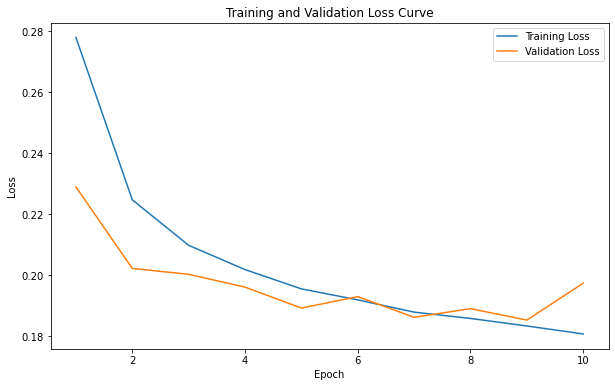

In [2]:
# Plot Training and Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_losses, label="Training Loss")
plt.plot(range(1, 11), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.show()

In [5]:
from torchinfo import summary

# Generate a summary of the model
model_summary = summary(
    model,
    input_data=(torch.randint(0, tokenizer.vocab_size, (1, 100)).to(device),  # Simulate input_ids
                torch.ones((1, 100), dtype=torch.long).to(device)),           # Simulate attention_mask
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=3  # Depth of nested modules to display
)

print(model_summary)


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
BertLSTMClassifier                                           [1, 100]                  [1, 2]                    --                        True
├─BertModel: 1-1                                             --                        [1, 768]                  --                        True
│    └─BertEmbeddings: 2-1                                   --                        [1, 100, 768]             --                        True
│    │    └─Embedding: 3-1                                   [1, 100]                  [1, 100, 768]             23,440,896                True
│    │    └─Embedding: 3-2                                   [1, 100]                  [1, 100, 768]             1,536                     True
│    │    └─Embedding: 3-3                                   [1, 100]                  [1, 100, 768]             393,216           

In [14]:
# Switch the model to evaluation mode
model.eval()

# Predictions and true labels
all_preds = []
all_labels = []

# Loop through test_loader to generate predictions
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:  # Unpack correctly
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask)  # Pass input_ids and attention_mask
        _, preds = torch.max(outputs, 1)  # Get the predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate a classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Non-Depression', 'Depression']))

# Print accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {accuracy:.4f}")

# Display confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(pd.DataFrame(conf_matrix, index=['Non-Depression', 'Depression'], 
                   columns=['Predicted Non-Depression', 'Predicted Depression']))


Classification Report:
                precision    recall  f1-score   support

Non-Depression       0.96      0.93      0.95     37311
    Depression       0.77      0.85      0.81      9621

      accuracy                           0.92     46932
     macro avg       0.86      0.89      0.88     46932
  weighted avg       0.92      0.92      0.92     46932

Overall Accuracy: 0.9167
Confusion Matrix:
                Predicted Non-Depression  Predicted Depression
Non-Depression                     34819                  2492
Depression                          1417                  8204


In [11]:
# Save the trained model
model_save_path = "lstm_depression_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to lstm_depression_model.pth


In [13]:
# Reload the model
loaded_model = BertLSTMClassifier().to(device)  # Reinitialize model architecture
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))
loaded_model.eval()  # Set model to evaluation mode
print("Model loaded successfully.")

# Example text input for inference
example_text = "I feel very sad and hopeless lately."

# Preprocess the text
encoded_input = tokenizer.encode_plus(
    example_text,
    add_special_tokens=True,
    max_length=100,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

input_ids = encoded_input["input_ids"].to(device)
attention_mask = encoded_input["attention_mask"].to(device)

# Inference
with torch.no_grad():
    output = loaded_model(input_ids, attention_mask)
    prediction = torch.argmax(output, dim=1).item()

print(f"Predicted Label: {prediction} (0: Not Depressed, 1: Depressed)")


/tmp/ipykernel_2657918/3397097680.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))


Model loaded successfully.
Predicted Label: 1 (0: Not Depressed, 1: Depressed)
